In [3]:
import pandas as pd
import numpy as np
from math import sqrt
pd.options.display.float_format = '{:.2f}'.format
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn import svm
from sklearn.linear_model import LinearRegression

In [5]:
"""
Importação dos datasets:
https://www.kaggle.com/olistbr/brazilian-ecommerce
"""

files = {'customers'    : 'olist/olist_customers_dataset.csv',
         'geolocation'  : 'olist/olist_geolocation_dataset.csv',
         'items'        : 'olist/olist_order_items_dataset.csv',
         'payment'      : 'olist/olist_order_payments_dataset.csv',
         'reviews'       : 'olist/olist_order_reviews_dataset.csv',
         'orders'       : 'olist/olist_orders_dataset.csv',
         'products'     : 'olist/olist_products_dataset.csv',
         'sellers'      : 'olist/olist_sellers_dataset.csv',
         'translation'  : 'olist/product_category_name_translation.csv'
         }


datasets = {}
for key, value in files.items():
    datasets[key] = pd.read_csv(value)
 
"""
99.441 consumidores
1.000.163 geolocalizações
112.650 itens vendidos
103.886 pagamentos
100.000 comentários
99.441 vendas
32.951 produtos
3.095 vendedores
71 categorias de produtos    
"""    
"""    
Junção das tabelas da base de dados em um só dataframe:
Foram selecionadas as tabelas com informações sobre o consumidor,
a localização e hora da venda, produtos e comentários sobre o produto
"""

#Join da tabela clientes e pedidos pela chave ID do cliente:
j1 = datasets['customers'].merge(datasets['orders'], how='inner', on='customer_id')
#Join da tabela itens pela chave ID da venda:
j2 = j1.merge(datasets['items'], how='inner', on='order_id')
#Join da tabela pagamentos pela chave ID do produto:
j3 = j2.merge(datasets['payment'], how='inner', on='order_id')
#Join da tabela produtos pela chave ID do produto:
j4 = j3.merge(datasets['products'], how='inner', on='product_id')
#Finalizando com join da tabela comentários pela chave ID da venda:
join_final = j4.merge(datasets['reviews'], how='left', on='order_id')

# Selecão dos atributos:
df = join_final[['customer_id','customer_unique_id',
       'customer_state','customer_city','order_id', 'order_status',
       'order_purchase_timestamp', 'order_delivered_carrier_date',
       'order_delivered_customer_date','order_estimated_delivery_date', 'product_id',
       'shipping_limit_date', 'price', 'payment_value','freight_value',
       'product_category_name','product_photos_qty',
       'review_score', 'review_comment_message']]

#Como os atributos relativos a data estão do tipo 'object', devemos convertê-los para 'datetime':

df.loc[:,'order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df.loc[:,'order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df.loc[:,'order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df.loc[:,'order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df.loc[:,'shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

#Iremos excluir da base toda o ano de 2016 e o mês de setembro de 2018, devido terem valores insignificantes:
df = df[(df['order_purchase_timestamp'].dt.year > 2016) 
              & 
              (df['order_purchase_timestamp'] < pd.to_datetime('20180901'))
             ]
df = df.reset_index(drop=True)

C:\Users\cesr1\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [4]:
df.dtypes

customer_id                              object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
product_id                               object
shipping_limit_date              datetime64[ns]
price                                   float64
payment_value                           float64
freight_value                           float64
product_category_name                    object
product_photos_qty                      float64
review_score                              int64
review_comment_message                   object
dtype: object

In [128]:
df.describe()

,price,payment_value,freight_value,product_photos_qty,review_score
count,117924.00,117924.00,117924.00,116217.00,117924.00
mean,120.61,172.51,20.03,2.20,4.02
std,184.13,267.28,15.84,1.72,1.40
min,0.85,0.00,0.00,1.00,1.00
25%,39.90,60.85,13.08,1.00,4.00
50%,74.90,108.18,16.28,1.00,5.00
75%,134.51,189.19,21.18,3.00,5.00
max,6735.00,13664.08,409.68,20.00,5.00


In [ ]:
#O que foi feito na fase de tratamento de dados:
#1. Exclusão da base toda o ano de 2016 e o mês de setembro de 2018, devido terem valores insignificantes: 
#2. Conversão dos atributos data para o tipo datetime

In [ ]:
#Análise Descritiva

#Alguns gráficos:

In [3]:
#função pra reduzir o tamanho dos valores (são muito altos):
import math
millnames = ['',' K',' mi',' bi',' tri']
def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
    return '{:.2f}{}'.format(n / 10**(3 * millidx), millnames[millidx])

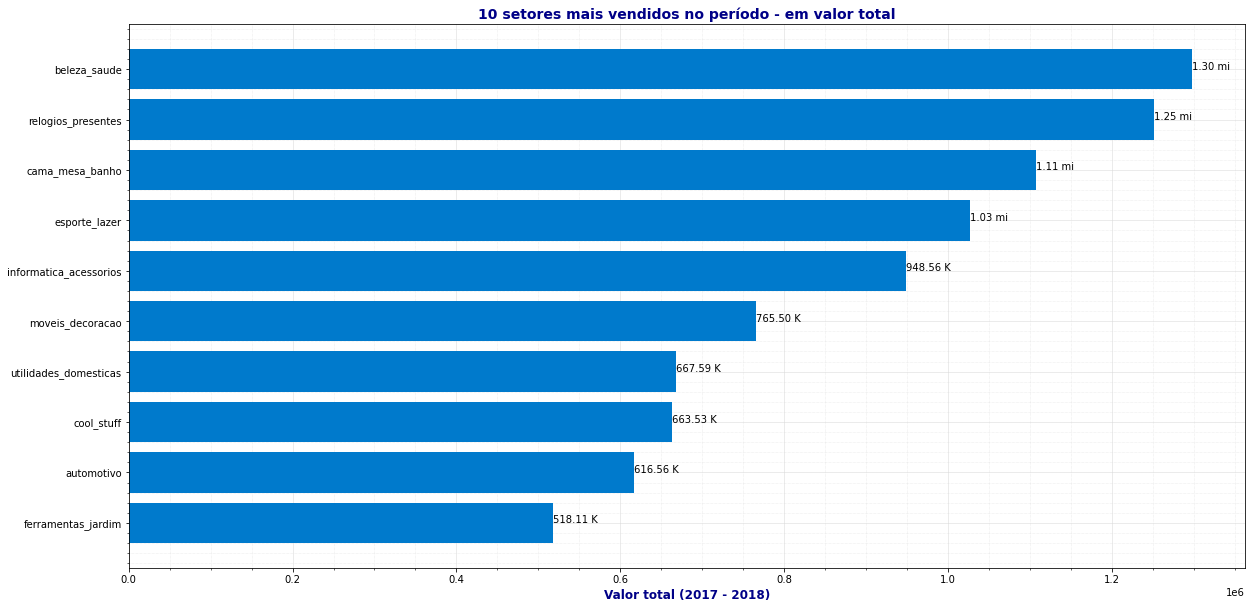

None

In [18]:
#10 Setores mais vendidos no período:

vendas_setor = pd.DataFrame([])
vendas_setor = df.groupby(['product_category_name'],as_index=False)['price'].sum()
vendas_setor = vendas_setor.sort_values(by=["price"],ascending=False) 
vendas_setor = vendas_setor.head(10)

#Eixos:
X = vendas_setor['product_category_name']
Y = vendas_setor['price']
#Títulos:
xlabel = 'Valor total (2017 - 2018)'
ylabel = ''
maintitle = '10 setores mais vendidos no período - em valor total'

#Criar gráfico:
fig,ax = plt.subplots(figsize=(20,10))
ax.barh(X,Y,color='#007acc')
ax.invert_yaxis()

#mostrar os valores nas barras
for index, value in enumerate(Y):
    plt.text(value, index, millify(value))

#formatar os títulos
ax.set_ylabel(ylabel,fontdict={'fontsize':12,'fontweight':'bold','color':'#000087'})
ax.set_xlabel(xlabel,fontdict={'fontsize':12,'fontweight':'bold','color':'#000087'})
ax.set_title(maintitle,fontdict={'fontsize':14,'fontweight':'bold','color':'#000087'})

#Adicionar grids:
ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', linestyle='-', linewidth='0.5', color='#d9d9d9') 
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='#d9d9d9')

display(plt.show())

In [9]:
#Em porcentagem:
vendas_pct = pd.DataFrame([])
vendas_pct = df.groupby(['product_category_name'],as_index=False)['price'].sum()
soma_vendas = df['price'].sum()
vendas_pct['category_pct'] = vendas_pct['price']/soma_vendas*100
vendas_pct = vendas_pct.sort_values(by=['category_pct'],ascending=False) 
vendas_pct

,product_category_name,price,category_pct
11,beleza_saude,1297239.69,9.12
66,relogios_presentes,1250962.71,8.80
13,cama_mesa_banho,1106918.99,7.78
32,esporte_lazer,1026298.24,7.22
44,informatica_acessorios,948561.37,6.67
...,...,...,...
41,flores,1110.04,0.01
15,casa_conforto_2,773.17,0.01
17,cds_dvds_musicais,730.00,0.01
37,fashion_roupa_infanto_juvenil,569.85,0.00


In [111]:
def mes_string(mes):
    if mes == 1:
        return 'janeiro'
    if mes == 2:
        return 'fevereiro'
    if mes == 3:
        return 'março'
    if mes == 4:
        return 'abril'
    if mes == 5:
        return 'maio'
    if mes == 6:
        return 'junho'
    if mes == 7:
        return 'julho'
    if mes == 8:
        return 'agosto'
    if mes == 9:
        return 'setembro'
    if mes == 10:
        return 'outubro'
    if mes == 11:
        return 'novembro'
    return 'dezembro'

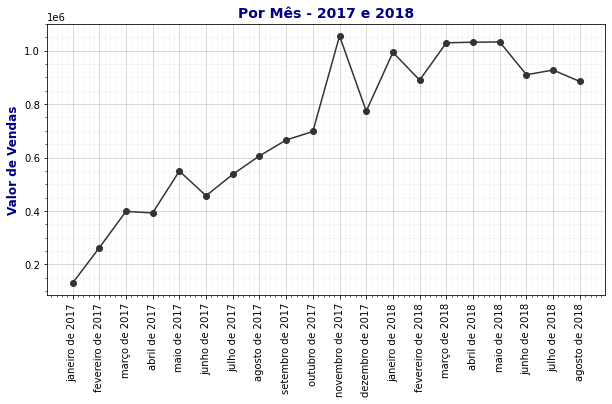

None

In [112]:
#Valor das vendas por mês:

vendas_mes = pd.DataFrame([])
vendas_mes['data'] = df['order_purchase_timestamp']
vendas_mes['mes'] = df['order_purchase_timestamp'].dt.month
vendas_mes['ano'] = df['order_purchase_timestamp'].dt.year
vendas_mes['price'] = df['price']
vendas_mes = vendas_mes.sort_values(by=["data"],ascending=True)
vendas_mes.drop(['data'], axis=1)
vendas_mes['mes'] = vendas_mes['mes'].apply (lambda row: mes_string(row))
vendas_mes['ano_mes'] = vendas_mes['mes'].astype(str) + ' de ' + vendas_mes['ano'].astype(str)
vendas_mes = vendas_mes.groupby(['ano_mes'],sort=False,as_index=False)['price'].sum()

#Eixos:
X = vendas_mes['ano_mes']
Y = vendas_mes['price']
#Títulos:
xlabel = 'Mês'
ylabel = 'Valor de Vendas'
maintitle = 'Por Mês - 2017 e 2018'

#Criar gráfico:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(X, Y, color='#333333', marker='o')
ax.set_ylabel(ylabel,fontdict={'fontsize':12,'fontweight':'bold','color':'#000087'})
y_pos = range(len(X))
plt.xticks(y_pos, X, rotation=90)
ax.set_title(maintitle,fontdict={'fontsize':14,'fontweight':'bold','color':'#000087'})
ax.set_axisbelow(True)

#Adicionar grids:
ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', linestyle='-', linewidth='-.55', color='#bfbfbf') 
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='#d9d9d9')

display(plt.show())

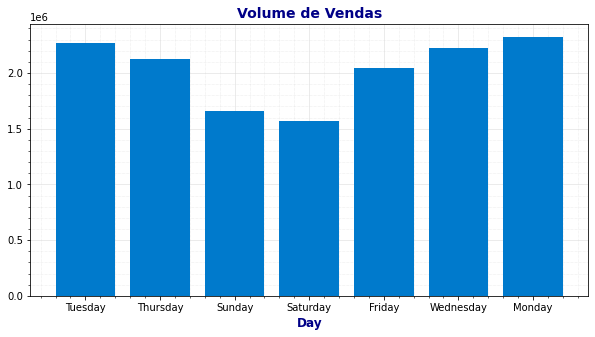

None

In [109]:
#Dia da semana:
diasdasemana = pd.DataFrame([])
diasdasemana['dia'] = df['order_purchase_timestamp']
diasdasemana['soma'] = df['price']
diasdasemana['dia'] = diasdasemana['dia'].apply(lambda x: x.strftime('%A'))
diasdasemana = diasdasemana.groupby(['dia'],sort=False,as_index=False)['soma'].sum()

#Eixos:
X = diasdasemana['dia']
Y = diasdasemana['soma']
#Títulos:
xlabel = 'Day'
maintitle = 'Volume de Vendas'

#Criar gráfico:
fig,ax = plt.subplots(figsize=(10,5))
ax.bar(X,Y,color='#007acc')
ax.set_xlabel(xlabel,fontdict={'fontsize':12,'fontweight':'bold','color':'#000087'})
ax.set_title(maintitle,fontdict={'fontsize':14,'fontweight':'bold','color':'#000087'})

#Adicionar grids:
ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', linestyle='-', linewidth='0.5', color='#d9d9d9') 
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='#d9d9d9')

display(plt.show())

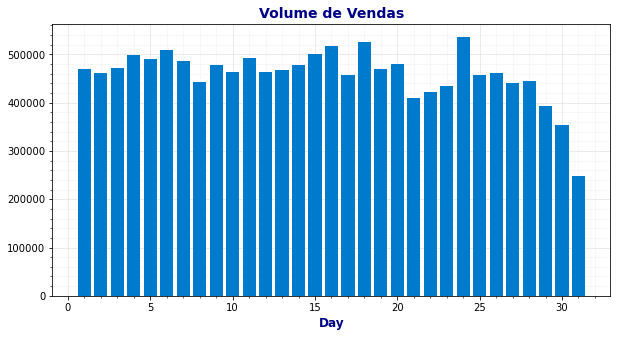

None

In [110]:
#Dia do mês:
diasdasemana = pd.DataFrame([])
diasdasemana['dia'] = df['order_purchase_timestamp'].dt.day
diasdasemana['soma'] = df['price']
diasdasemana = diasdasemana.groupby(['dia'],sort=False,as_index=False)['soma'].sum()

#Eixos:
X = diasdasemana['dia']
Y = diasdasemana['soma']
#Títulos:
xlabel = 'Day'
maintitle = 'Volume de Vendas'

#Criar gráfico:
fig,ax = plt.subplots(figsize=(10,5))
ax.bar(X,Y,color='#007acc')
ax.set_xlabel(xlabel,fontdict={'fontsize':12,'fontweight':'bold','color':'#000087'})
ax.set_title(maintitle,fontdict={'fontsize':14,'fontweight':'bold','color':'#000087'})

#Adicionar grids:
ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', linestyle='-', linewidth='0.5', color='#d9d9d9') 
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='#d9d9d9')

display(plt.show())

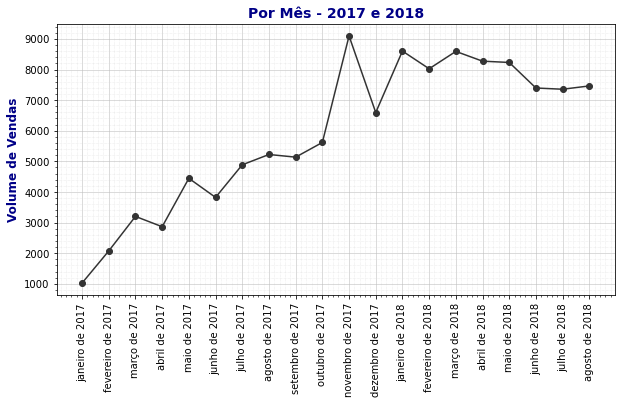

None

In [25]:
#Valor das vendas por mês:

volume_mes = pd.DataFrame([])
volume_mes['data'] = df['order_purchase_timestamp']
volume_mes['mes'] = df['order_purchase_timestamp'].dt.month
volume_mes['ano'] = df['order_purchase_timestamp'].dt.year
volume_mes['amount'] = df['customer_id']
volume_mes = volume_mes.sort_values(by=["data"],ascending=True)
volume_mes.drop(['data'], axis=1)
volume_mes['mes'] = volume_mes['mes'].apply (lambda row: mes_string(row))
volume_mes['ano_mes'] = volume_mes['mes'].astype(str) + ' de ' + volume_mes['ano'].astype(str)
volume_mes = volume_mes.groupby(['ano_mes'],sort=False,as_index=False)['amount'].count().reset_index()

#Eixos:
X = volume_mes['ano_mes']
Y = volume_mes['amount']
#Títulos:
xlabel = 'Mês'
ylabel = 'Volume de Vendas'
maintitle = 'Por Mês - 2017 e 2018'

#Criar gráfico:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(X, Y, color='#333333', marker='o')
ax.set_ylabel(ylabel,fontdict={'fontsize':12,'fontweight':'bold','color':'#000087'})
y_pos = range(len(X))
plt.xticks(y_pos, X, rotation=90)
ax.set_title(maintitle,fontdict={'fontsize':14,'fontweight':'bold','color':'#000087'})
ax.set_axisbelow(True)

#Adicionar grids:
ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', linestyle='-', linewidth='-.55', color='#bfbfbf') 
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='#d9d9d9')

display(plt.show())

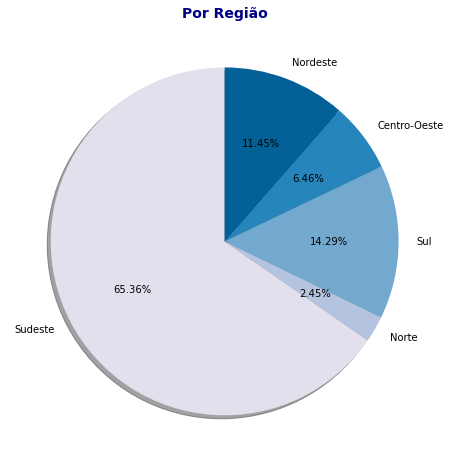

None

In [12]:
#Por região:

por_regiao = pd.DataFrame([])
por_regiao['uf'] = df['customer_state']
por_regiao['price'] = df['price']

def classificarEstado (row):
   if row['uf'] in(['AM','PA','AC','RO','RR','AP','TO']):
      return 'Norte'
   if row['uf'] in(['MA','PI','CE','RN','PB','PE','AL','SE','BA']):
      return 'Nordeste'
   if row['uf'] in(['PR','SC','RS']):
      return 'Sul'
   if row['uf'] in(['SP','RJ','ES','MG']):
      return 'Sudeste'
   return 'Centro-Oeste'

por_regiao['regiao'] = por_regiao.apply (lambda row: classificarEstado(row), axis=1)
por_regiao = por_regiao.groupby(['regiao'],sort=False,as_index=False)['price'].sum()

nomes = por_regiao['regiao']
fatias = por_regiao['price']
soma = por_regiao['price'].sum()
por_regiao['percent'] = por_regiao['price']/soma*100
#selecionar paleta de cores
custom_palette = sns.color_palette("PuBu", 5)

#Criar gráfico:
maintitle = 'Por Região'
fig,ax = plt.subplots(figsize=(15,8))
ax.set_title(maintitle,fontdict={'fontsize':14,'fontweight':'bold','color':'#000087'})
ax.pie(fatias, labels = nomes, colors = custom_palette, startangle = 90, shadow = True,autopct='%1.2f%%')

display(plt.show())

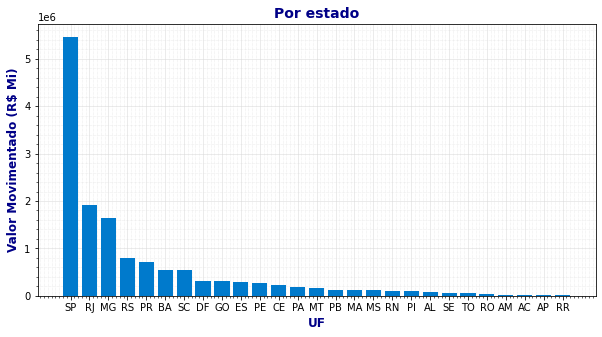

None

In [13]:
#Por estado:

por_estado = pd.DataFrame([])
por_estado['uf'] = df['customer_state']
por_estado['price'] = df['price']
por_estado = por_estado.groupby(['uf'],sort=False,as_index=False)['price'].sum()
por_estado = por_estado.sort_values(by=['price'],ascending=False)

xlabel = 'UF'
ylabel = 'Valor Movimentado (R$ Mi)'
maintitle = 'Por estado'

X = por_estado['uf']
Y = por_estado['price']

#Criar gráfico:
fig,ax = plt.subplots(figsize=(10,5))
ax.bar(X,Y,color='#007acc')
ax.set_ylabel(ylabel,fontdict={'fontsize':12,'fontweight':'bold','color':'#000087'})
ax.set_xlabel(xlabel,fontdict={'fontsize':12,'fontweight':'bold','color':'#000087'})
ax.set_title(maintitle,fontdict={'fontsize':14,'fontweight':'bold','color':'#000087'})

#Adicionar grids:
ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', linestyle='-', linewidth='0.5', color='#d9d9d9') 
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='#d9d9d9')

display(plt.show())

In [14]:
#criar uma nuvem de palavras pra cada nota de cliente para verificarmos quais as palavras mais usadas:

#função para remover as stopwords da nossa base:
def removeStopWords(texto):
    for palavras in texto:
        semStop = [p for p in texto.split() if p not in stopwords]
    return semStop

#Aplicar a função remover stopwords em todos os comentários:
stopwords = nltk.corpus.stopwords.words('portuguese')
comentarios = df[['review_comment_message','review_score']]
comentarios = comentarios.dropna(how='any',axis=0)
comentarios['review_comment_message'] = comentarios['review_comment_message'].str.lower()
comentarios['review_comment_message'] = comentarios['review_comment_message'].apply(lambda x : removeStopWords(x))

In [37]:
comments_1 = comentarios[(comentarios.review_score == 1)]
comments_5 = comentarios[(comentarios.review_score == 5)]
comments_1 = comments_1[['review_comment_message']]
comments_5 = comments_5[['review_comment_message']]
comments_1_wordcloud = comments_1['review_comment_message'].apply(' '.join)
comments_5_wordcloud = comments_5['review_comment_message'].apply(' '.join)
comments_1_wordcloud = comments_1_wordcloud.reset_index(drop=True)
comments_5_wordcloud = comments_5_wordcloud.reset_index(drop=True)

#função que cria uma string com todas as palavras usadas nos comentários, já excluídas as stopwords:
def generateString(object):
    string = ''
    for i in object:
        string = string+' '+i
    return string
        
string_1 = generateString(comments_1_wordcloud)
string_5 = generateString(comments_5_wordcloud)

#Gerar a wordcloud a partir da string gerada:
def gerarWordCloud(string):
    #gerar a wordcloud:
    wordcloud = WordCloud(stopwords=stopwords,
                      background_color="black",
                      width=1600, height=800).generate(string_1)
    # mostrar a nuvem:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_axis_off()
    plt.imshow(wordcloud)

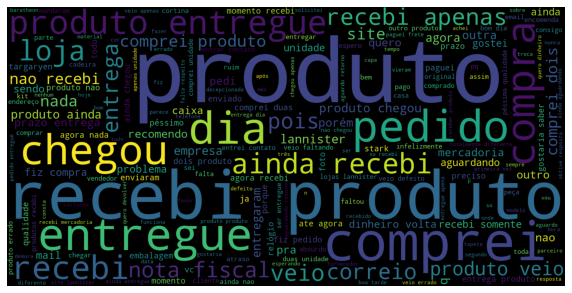

In [27]:
gerarWordCloud(string_1)

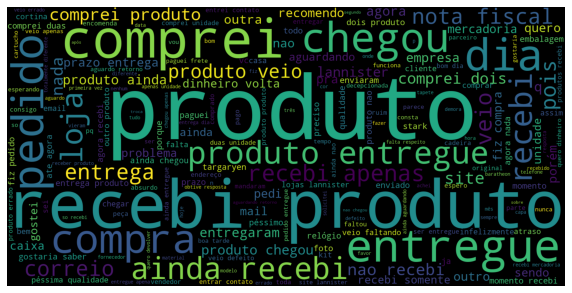

In [31]:
gerarWordCloud(string_5)

In [ ]:
#Não deu pra tirar nenhuma conclusão a partir das wordclouds de nota 1 e 5 

In [8]:
#Vamos criar uma tabela com os dados sobre compra, entrega e frete e nota do cliente:
entrega_satisfacao = pd.DataFrame([])
entrega_satisfacao = df[['customer_state',
                         'customer_city',
                         'price',
                         'freight_value',
                         'product_photos_qty',
                         'order_purchase_timestamp',
                         'order_delivered_customer_date',
                         'order_estimated_delivery_date',
                         'review_score'
                        ]]
entrega_satisfacao = entrega_satisfacao.dropna(how='any',axis=0)
#Criar colunas tempo de entrega e atraso na entrega:
entrega_satisfacao['delivery_time'] = (entrega_satisfacao['order_delivered_customer_date'].dt.date - entrega_satisfacao['order_purchase_timestamp'].dt.date).dt.days
entrega_satisfacao['delivery_delay'] = np.where(entrega_satisfacao['order_estimated_delivery_date'] < 
                                                entrega_satisfacao['order_delivered_customer_date'],
                                                (entrega_satisfacao['order_delivered_customer_date'].dt.date -
                                                entrega_satisfacao['order_estimated_delivery_date'].dt.date).dt.days,0)                                       
        

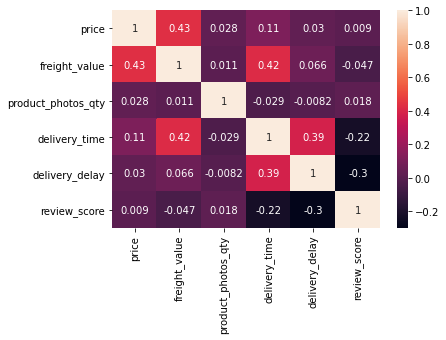

In [160]:
#Vamos achar as variáveis que mais se correlacionam:


correlation_score = entrega_satisfacao[[ 'price',
                                         'freight_value',
                                         'product_photos_qty',
                                         'delivery_time',
                                         'delivery_delay',
                                         'review_score']]

"""
Especialmente quando uma ou ambas as variáveis são medidas em escala ordinal, o coeficiente de correlação de Spearman
é mais adequado que o de Pearson, por levar em consideração a ordem dos dados e não o seu valor intrínseco.
Em uma relação monotônica, as variáveis tendem a mudar juntas, mas não necessariamente a uma taxa constante.
O coeficiente de correlação de Spearman baseia-se nos valores classificados de cada variável, em vez de os dados brutos.
Ou seja, caso não seja observada uma relação linear entre as variáveis, o coeficiente de Spearman é uma ótima alternativa.
"""

correlation_mat = correlation_score.corr(method='spearman')
sns.heatmap(correlation_mat, annot = True)
plt.show()
#Nota-se que variáveis mais significativas são delivery_time e delivery_delay, nos seguintes termos:
#delivery_time - correlação negativa com coeficiente -0.31
#delivery_delay - correlação negativa com coeficiente -0.24
#Podemos interpretar que delivery_time e review_score  possuem correlação desprezível (0 a 0.3)
#já o coeficiente das variáveis delivery_delay e review_score indica correlação fraca(0.3 a 0.5).

In [24]:
#Verificar quais cidades que mais têm problema com entrega
atraso_entrega = pd.DataFrame([])
cidades_entrega = pd.DataFrame([])

cidades_entrega = pd.DataFrame(entrega_satisfacao['customer_city'])
cidades_entrega = cidades_entrega.value_counts()
cidades_entrega = pd.DataFrame(cidades_entrega,columns={'sales'})

atraso_entrega = entrega_satisfacao.loc[entrega_satisfacao['delivery_delay'] > 0 ,['customer_city','delivery_delay']]
atraso_entrega = atraso_entrega.groupby(['customer_city']).count()

entrega_final = atraso_entrega.merge(cidades_entrega, how='inner', on='customer_city')
entrega_final = entrega_final.loc[entrega_final['sales'] > 100]
entrega_final['%'] = entrega_final['delivery_delay']/entrega_final['sales']*100
entrega_final = entrega_final.sort_values(by=["%"],ascending=False)
print(entrega_final.head(20))

                    delivery_delay  sales     %
customer_city                                  
maceio                          70    258 27.13
sao goncalo                     97    442 21.95
sao luis                        77    380 20.26
cabo frio                       30    156 19.23
teresina                        57    304 18.75
nova friburgo                   31    167 18.56
angra dos reis                  19    108 17.59
rio das ostras                  25    150 16.67
fortaleza                      110    716 15.36
volta redonda                   39    254 15.35
chapeco                         19    127 14.96
macae                           39    266 14.66
marica                          22    152 14.47
sao joao de meriti              24    167 14.37
salvador                       207   1445 14.33
aracaju                         34    244 13.93
natal                           34    245 13.88
resende                         19    138 13.77
hortolandia                     21    15

In [318]:
entrega_final.describe()

,delivery_delay,sales,%
count,1180.00,1180.00,1180.00
mean,6.30,84.37,24.64
std,36.11,597.41,28.45
min,1.00,1.00,0.61
25%,1.00,5.00,6.00
50%,1.00,14.00,12.50
75%,3.00,47.25,30.00
max,828.00,17965.00,100.00


In [6]:
#Verificar quais estados possuem as melhores avaliações dos produtos:

def getSentiment (row):
   if row == 1 or row == 2:
      return 'Negative'
   if row == 4 or row == 5:
      return 'Positive'
   return 'Regular'
#todas as vendas
all_sales = df.groupby(['customer_state'],sort=False,as_index=False)['order_id'].count()
all_sales.set_index('customer_state')
all_sales = all_sales.sort_values(by=['order_id'],ascending=False)
#classificação das avaliações:
rating_uf = df[['customer_state','review_score']]
rating_uf.set_index('customer_state')

rating_uf = rating_uf.merge(all_sales, how='inner', on='customer_state')

rating_uf['review_score'] = rating_uf['review_score'].apply (lambda row: getSentiment(row))
rating_uf_positive = rating_uf.loc[rating_uf['review_score'] == 'Positive']
rating_uf_negative = rating_uf.loc[rating_uf['review_score'] == 'Negative']
rating_uf_regular = rating_uf.loc[rating_uf['review_score'] == 'Regular']

rating_uf_positive = rating_uf_positive.groupby(['customer_state'],sort=False,as_index=False)['review_score'].count()
rating_uf_negative = rating_uf_negative.groupby(['customer_state'],sort=False,as_index=False)['review_score'].count()
rating_uf_regular = rating_uf_regular.groupby(['customer_state'],sort=False,as_index=False)['review_score'].count()


rating_uf_positive = rating_uf_positive.merge(all_sales, on='customer_state')
rating_uf_negative = rating_uf_negative.merge(all_sales, on='customer_state')
rating_uf_regular = rating_uf_regular.merge(all_sales,  on='customer_state')

rating_uf_positive['percent'] = rating_uf_positive['review_score']/rating_uf_positive['order_id']*100
rating_uf_negative['percent'] = rating_uf_negative['review_score']/rating_uf_negative['order_id']*100
rating_uf_regular['percent'] = rating_uf_regular['review_score']/rating_uf_regular['order_id']*100

rating_uf_positive = rating_uf_positive[['customer_state','percent']]
rating_uf_negative = rating_uf_negative[['customer_state','percent']]
rating_uf_regular = rating_uf_regular[['customer_state','percent']]

rating_uf_positive = rating_uf_positive.sort_values(by=['percent'],ascending=False)
rating_uf_negative = rating_uf_negative.sort_values(by=['percent'],ascending=False)
rating_uf_regular = rating_uf_regular.sort_values(by=['percent'],ascending=False)

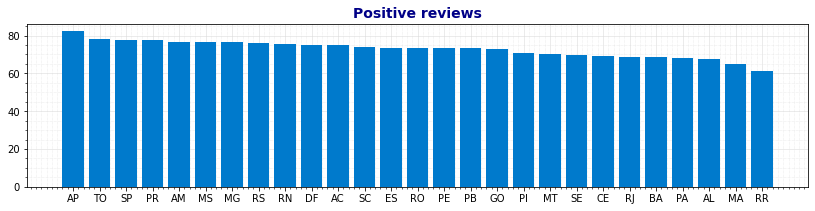

None

In [112]:
X = rating_uf_positive['customer_state']
Y = rating_uf_positive['percent']

maintitle = 'Positive reviews'

#Criar gráfico:
fig,ax = plt.subplots(figsize=(14,3))
ax.bar(X,Y,color='#007acc')
ax.set_title(maintitle,fontdict={'fontsize':14,'fontweight':'bold','color':'#000087'})

#Adicionar grids:
ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', linestyle='-', linewidth='0.5', color='#d9d9d9') 
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='#d9d9d9')
display(plt.show())

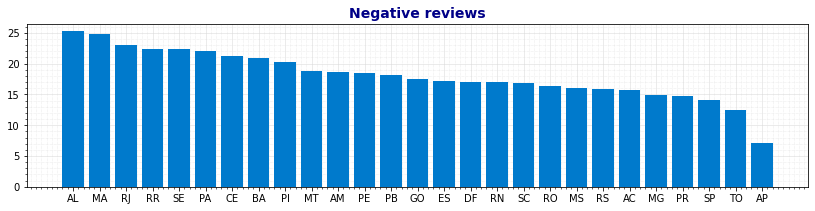

None

In [78]:
X = rating_uf_negative['customer_state']
Y = rating_uf_negative['percent']

maintitle = 'Negative reviews'

#Criar gráfico:
fig,ax = plt.subplots(figsize=(14,3))
ax.bar(X,Y,color='#007acc')
ax.set_title(maintitle,fontdict={'fontsize':14,'fontweight':'bold','color':'#000087'})

#Adicionar grids:
ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', linestyle='-', linewidth='0.5', color='#d9d9d9') 
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='#d9d9d9')
display(plt.show())

<AxesSubplot:title={'center':'Atrasos'}, xlabel='customer_state'>

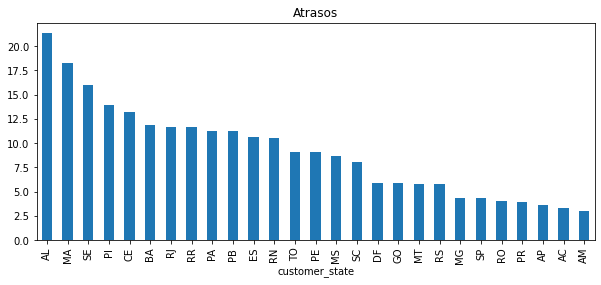

In [79]:
#estados que tiveram mais atraso:
estados_atraso = entrega_satisfacao.loc[entrega_satisfacao['delivery_delay'] > 0,['customer_state']]
estados_atraso = pd.DataFrame(estados_atraso.value_counts(),columns={'atrasos'})
pedidos = pd.DataFrame(entrega_satisfacao['customer_state'])
pedidos = pd.DataFrame(pedidos.value_counts(),columns={'pedidos'})
estados_atraso = estados_atraso.merge(pedidos, on='customer_state')
#porcentagem:
estados_atraso['percent'] = estados_atraso['atrasos']/estados_atraso['pedidos']*100
estados_atraso = estados_atraso.sort_values(by=['percent'],ascending=False)
#plot
estados_atraso['percent'].plot.bar(figsize=(10,4),title='Atrasos')



In [10]:
# Por Mês:

orders_month_beleza_saude = pd.DataFrame([])
orders_month_cama_mesa_banho = pd.DataFrame([])
orders_month = pd.DataFrame([])

orders_month_beleza_saude = df.loc[df['product_category_name'] == 'beleza_saude',['price','order_purchase_timestamp']]
orders_month_beleza_saude = orders_month_beleza_saude.sort_values(by=["order_purchase_timestamp"],ascending=True)
orders_month_cama_mesa_banho = df.loc[df['product_category_name'] == 'cama_mesa_banho',['price','order_purchase_timestamp']]
orders_month_cama_mesa_banho = orders_month_cama_mesa_banho.sort_values(by=["order_purchase_timestamp"],ascending=True)
orders_month = df[['price','order_purchase_timestamp']]
orders_month = orders_month.sort_values(by=["order_purchase_timestamp"],ascending=True)

orders_month_beleza_saude['mes_ano'] = orders_month_beleza_saude['order_purchase_timestamp'].dt.to_period("M").astype(str)
orders_month_cama_mesa_banho['mes_ano'] = orders_month_cama_mesa_banho['order_purchase_timestamp'].dt.to_period("M").astype(str)
orders_month['mes_ano'] = orders_month['order_purchase_timestamp'].dt.to_period("M").astype(str)

orders_month_beleza_saude = orders_month_beleza_saude[['mes_ano','price']]
orders_month_cama_mesa_banho = orders_month_cama_mesa_banho[['mes_ano','price']]
orders_month = orders_month[['mes_ano','price']]

orders_month_beleza_saude = orders_month_beleza_saude.groupby(['mes_ano'],sort=False,as_index=False)['price'].sum()
orders_month_cama_mesa_banho = orders_month_cama_mesa_banho.groupby(['mes_ano'],sort=False,as_index=False)['price'].sum()
orders_month = orders_month.groupby(['mes_ano'],sort=False,as_index=False)['price'].sum()

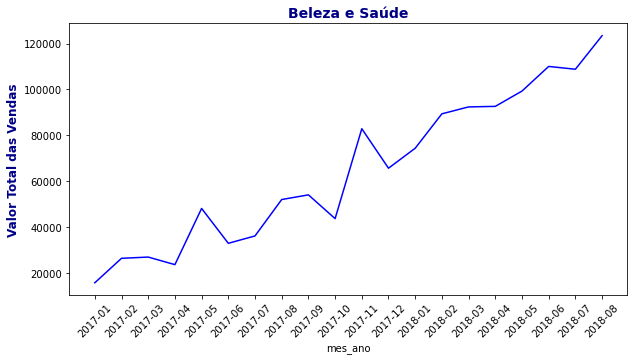

None

In [130]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(x='mes_ano', y='price', data=orders_month_beleza_saude, color="b")
ax.set_ylabel('Valor Total das Vendas',fontdict={'fontsize':12,'fontweight':'bold','color':'#000087'})
ax.set_title('Beleza e Saúde',fontdict={'fontsize':14,'fontweight':'bold','color':'#000087'})
plt.xticks(rotation=45)
display(plt.show())

In [ ]:
"""
Primeiramente vamos verificar se nossas séries são estacionárias:

Uma série estacionária tem média constante durante o tempo,
não existe tendências de alta ou de baixa. A razão disso é
que tendo uma média constante com variações ao redor desta média
fica muito mais fácil de extrapolar ao futuro.
Uma série temporal estacionária é aquela cujas propriedades estatísticas,
como a média, a variância e a auto correlação, são constantes ao longo do tempo. 

A série é estacionária se a média e a variância são constantes pelo tempo

tudo o que precisamos nos preocupar são os números que vemos em "Estatística de Teste" e "Valores Críticos".
Sempre queremos que o primeiro seja menor do que o último. E quanto menor o valor da estatística de teste, melhor.
"""

In [6]:
#Teste de estacionaridade de Dickey-Fuller:
def df_test(timeseries,window = 12, cutoff = 0.01):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    print(dfoutput)

In [9]:
df_test(orders_month_beleza_saude['price'])

Results of Dickey-Fuller Test:
p-value = 0.9968. The series is likely non-stationary.
Test Statistic                 1.34
p-value                        1.00
Lags Used                      3.00
Number of Observations Used   16.00
Critical Value (1%)           -3.92
Critical Value (5%)           -3.07
Critical Value (10%)          -2.67
dtype: float64


In [31]:
diff_bs = pd.Series(orders_month_beleza_saude['price'].diff().values, index = orders_month_beleza_saude['mes_ano'])
diff_bs.dropna(inplace = True)

In [126]:
model = pm.auto_arima(orders_month_beleza_saude['price'], start_p=1, start_q=1,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=0,              
                      d=None,           
                      seasonal=False,
                      start_P=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=418.073, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=412.144, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=422.622, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=419.383, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=401.561, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=398.490, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=400.137, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=414.938, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=417.268, Time=0.07 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 0.729 seconds


predicted=91336.650135, expected=89346.210000
predicted=82274.637629, expected=92354.050000
predicted=94831.868560, expected=92590.450000
predicted=104648.263897, expected=99273.510000
predicted=106154.417244, expected=110025.340000


C:\Users\cesr1\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=109403.810574, expected=108797.080000
predicted=116861.796087, expected=123448.500000
Test RMSE: 5321.186


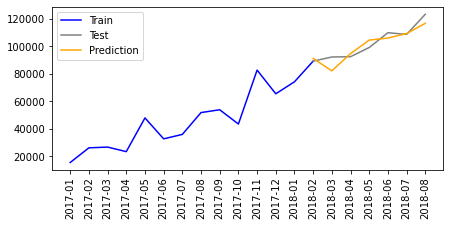

In [88]:
# dividir a base com 34% para teste:
X = orders_month_beleza_saude['price'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = SARIMAX(history, order=(3,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
#Imprimir o erro quadrático médio:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
fig,ax = plt.subplots(figsize=(7,3))
plt.plot(orders_month_beleza_saude['mes_ano'][:len(train)+1], orders_month_beleza_saude['price'][:len(train)+1], 'blue',
         orders_month_beleza_saude['mes_ano'][len(train):], orders_month_beleza_saude['price'][len(train):], 'gray',
         orders_month_beleza_saude['mes_ano'][len(train):], predictions, 'orange')
plt.legend(["Train","Test","Prediction"])
plt.xticks(rotation=90)
plt.show()

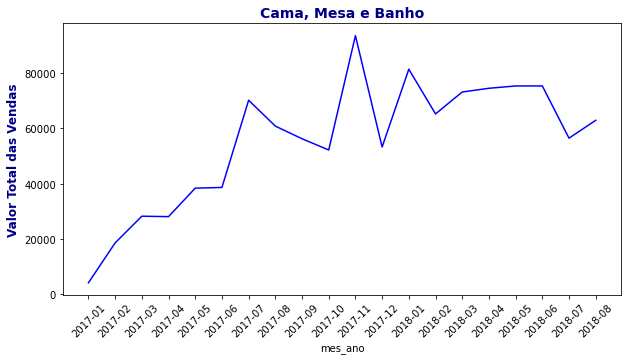

None

In [404]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(x='mes_ano', y='price', data=orders_month_cama_mesa_banho, color="b")
ax.set_ylabel('Valor Total das Vendas',fontdict={'fontsize':12,'fontweight':'bold','color':'#000087'})
ax.set_title('Cama, Mesa e Banho',fontdict={'fontsize':14,'fontweight':'bold','color':'#000087'})
plt.xticks(rotation=45)
display(plt.show())

In [407]:
#Primeiro passo - Teste de Estacionaridade:
df_test(orders_month_cama_mesa_banho['price'])

Results of Dickey-Fuller Test:
p-value = 0.9791. The series is likely non-stationary.
Test Statistic                 0.34
p-value                        0.98
Lags Used                      8.00
Number of Observations Used   11.00
Critical Value (1%)           -4.22
Critical Value (5%)           -3.19
Critical Value (10%)          -2.73
dtype: float64


In [134]:
#Segundo passo - Achar uma combinação aproximada para os parâmetros do ARIMA por meio da função auto_arima:
model = pm.auto_arima(orders_month_cama_mesa_banho['price'], start_p=1, start_q=1,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=0,              
                      d=None,           
                      seasonal=False,
                      start_P=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=425.031, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=430.335, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=423.012, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=426.567, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=428.910, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=425.015, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=426.919, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=423.121, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.349 seconds


predicted=60732.227093, expected=65233.580000
predicted=76697.773720, expected=73156.030000
predicted=67611.375157, expected=74502.560000
predicted=74108.255898, expected=75339.560000
predicted=74933.868583, expected=75344.760000
predicted=75383.613636, expected=56471.660000
predicted=67168.122590, expected=62928.290000
Test RMSE: 8085.416


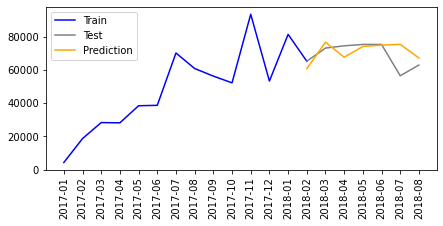

In [91]:
#Quarto e último passo - Dividir a base em treino e teste e apresentar os resultados:
# split into train and test sets
X = orders_month_cama_mesa_banho['price'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
#Accuracy Metrics for Time Series Forecast:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
fig,ax = plt.subplots(figsize=(7,3))
plt.plot(orders_month_cama_mesa_banho['mes_ano'][:len(train)+1], orders_month_cama_mesa_banho['price'][:len(train)+1], 'blue',
         orders_month_cama_mesa_banho['mes_ano'][len(train):], orders_month_cama_mesa_banho['price'][len(train):], 'gray',
         orders_month_cama_mesa_banho['mes_ano'][len(train):], predictions, 'orange')
plt.legend(["Train","Test","Prediction"])
plt.xticks(rotation=90)
plt.show()

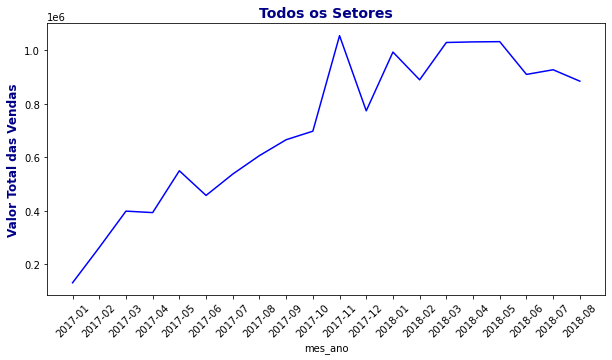

None

In [405]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(x='mes_ano', y='price', data=orders_month, color="b")
ax.set_ylabel('Valor Total das Vendas',fontdict={'fontsize':12,'fontweight':'bold','color':'#000087'})
ax.set_title('Todos os Setores',fontdict={'fontsize':14,'fontweight':'bold','color':'#000087'})
plt.xticks(rotation=45)
display(plt.show())

In [10]:
df_test(orders_month['price'])

Results of Dickey-Fuller Test:
p-value = 0.1340. The series is likely non-stationary.
Test Statistic                -2.43
p-value                        0.13
Lags Used                      1.00
Number of Observations Used   18.00
Critical Value (1%)           -3.86
Critical Value (5%)           -3.04
Critical Value (10%)          -2.66
dtype: float64


In [26]:
diff_all = pd.Series(orders_month['price'].diff().values, index = orders_month['mes_ano'])
diff_all.dropna(inplace = True)

In [130]:
model = pm.auto_arima(orders_month['price'], start_p=1, start_q=1,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=0,              
                      d=None,           
                      seasonal=False,
                      start_P=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=479.141, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=502.529, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=482.239, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=495.055, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=500.660, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=479.705, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=482.106, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=486.598, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=479.933, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=479.986, Time=0.14 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=475.989, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=486.731, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=480.461, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=477.986, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=479.4

C:\Users\cesr1\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted=948984.878113, expected=889777.190000
predicted=1073600.524625, expected=1029589.670000
predicted=1025954.274392, expected=1031745.620000
predicted=1129991.553337, expected=1032699.420000
predicted=1113779.169474, expected=910053.030000
predicted=1021469.338674, expected=927401.380000
predicted=902953.638166, expected=884731.520000
Test RMSE: 96826.038


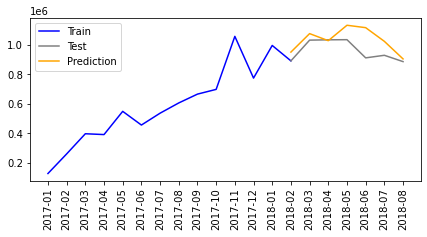

In [93]:
X = orders_month['price'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,2,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
#Accuracy Metrics for Time Series Forecast:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
fig,ax = plt.subplots(figsize=(7,3))
plt.plot(orders_month['mes_ano'][:len(train)+1], orders_month['price'][:len(train)+1], 'blue',
         orders_month['mes_ano'][len(train):], orders_month['price'][len(train):], 'gray',
         orders_month['mes_ano'][len(train):], predictions, 'orange')
plt.legend(["Train","Test","Prediction"])
plt.xticks(rotation=90)
plt.show()

In [ ]:
#no exemplo acima houve 12% de erro no ajuste.

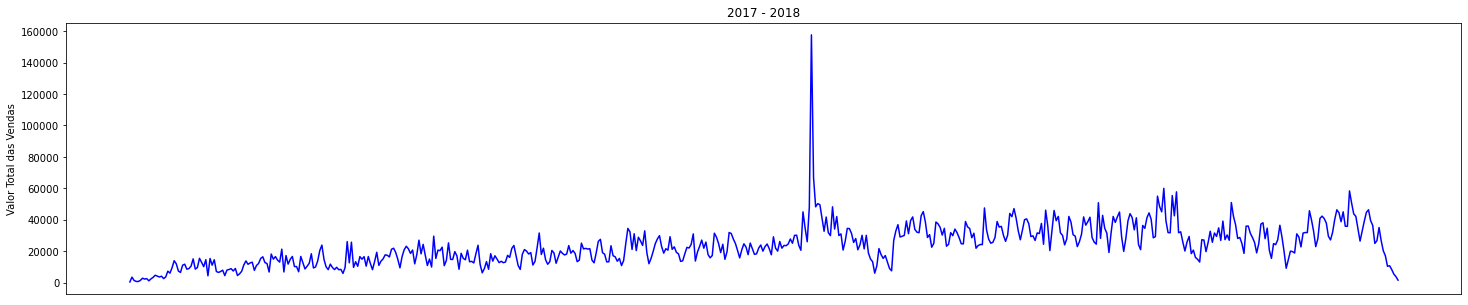

Maior valor no dia: [['2017-11-24']]


In [14]:
plt.figure(figsize=(25,5))
plt.title('2017 - 2018')
plt.plot(orders_days['ano_semana'],orders_days['price'], color='blue')
plt.ylabel('Valor Total das Vendas')
plt.xticks([])
plt.show()
print('Maior valor no dia:',orders_days.loc[orders_days['price'] == orders_days['price'].max(),['ano_semana']].values)
#Percebe-se a tendência na Black Friday em 24 de novembro de 2017
#Tendência (trend) : É algo que acontece e some depois. Não se repete constantemente. É uma situação especifica. Pode ser crescente (uptrend) ou decrescente (downtrend).
#Sazonalidade (seasonality) : É um evento que acontece repetidamente e que afeta o dataset concernido. Por exemplo: Natal.

In [56]:
orders_days['ano_semana'].head(1)

0    2017-01-05
Name: ano_semana, dtype: object

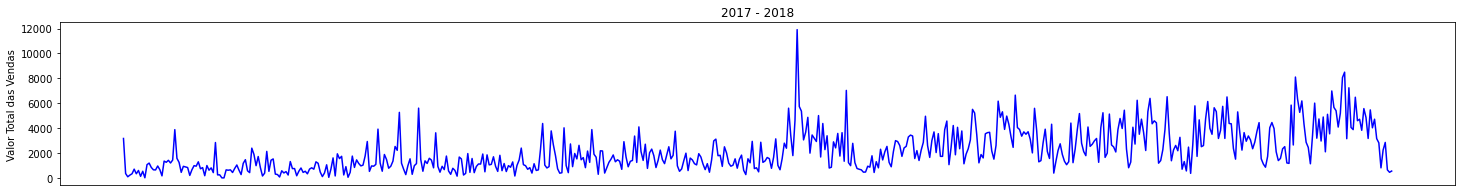

Maior valor no dia: [['2017-11-24']]


In [54]:
plt.figure(figsize=(25,3))
plt.title('2017 - 2018')
plt.plot(orders_days_beleza_saude['ano_semana'],orders_days_beleza_saude['price'], color='blue')
plt.ylabel('Valor Total das Vendas')
plt.xticks([])
plt.show()
print('Maior valor no dia:',orders_days_beleza_saude.loc[orders_days_beleza_saude['price'] == orders_days_beleza_saude['price'].max(),['ano_semana']].values)

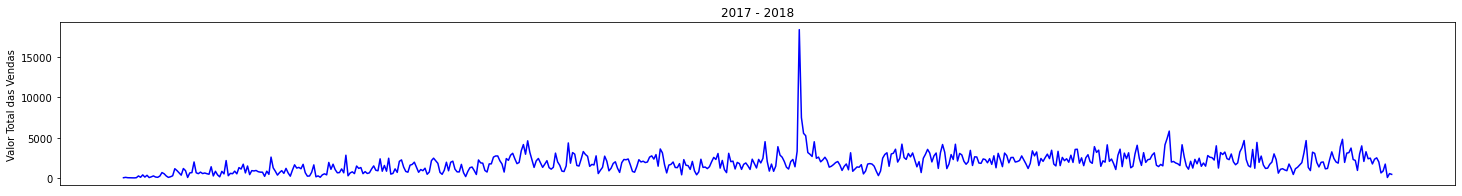

Maior valor no dia: [['2017-11-24']]


In [55]:
plt.figure(figsize=(25,3))
plt.title('2017 - 2018')
plt.plot(orders_days_cama_mesa_banho['ano_semana'],orders_days_cama_mesa_banho['price'], color='blue')
plt.ylabel('Valor Total das Vendas')
plt.xticks([])
plt.show()
print('Maior valor no dia:',orders_days_cama_mesa_banho.loc[orders_days_cama_mesa_banho['price'] == orders_days_cama_mesa_banho['price'].max(),['ano_semana']].values)

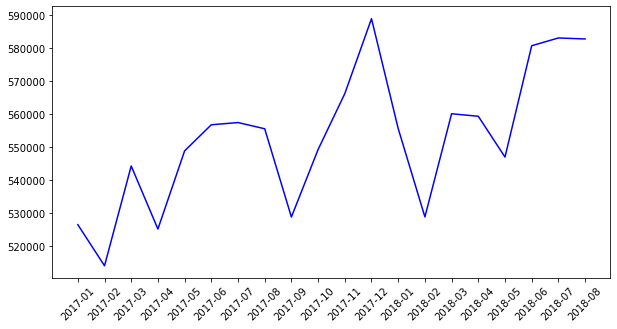

In [8]:
#Importar tabela com PIB mensal (fonte:Ipea)
pib_mes = pd.read_csv(r'pib_mes.csv')
pib_mes.columns=['mes','pib']
for col in pib_mes:
    pib_mes['pib'] = pib_mes['pib'].map(lambda x: x.replace(';',''))
pib_mes['pib'] = pib_mes['pib'].astype(float)
#apenas o período de interesse:
pib_mes_train = pib_mes[:20]
# plot
fig,ax = plt.subplots(figsize=(10,5))
plt.plot(pib_mes_train['mes'], pib_mes_train['pib'], 'b')
plt.xticks(rotation=45)
plt.show()

In [14]:
print('Table: PIB')
pib_mes.info(verbose=True)

Table: PIB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mes     47 non-null     object 
 1   pib     47 non-null     float64
dtypes: float64(1), object(1)
memory usage: 880.0+ bytes


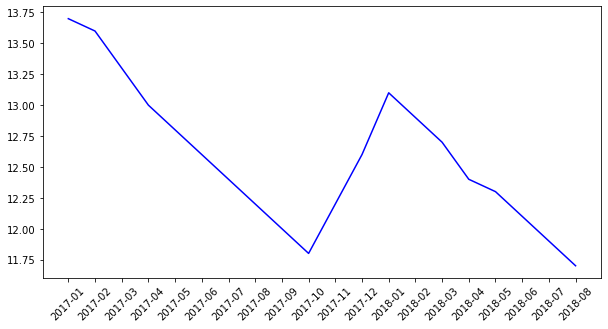

In [15]:
#Importar tabela com taxa de desemprego mensal(fonte:IBGE)
desemprego = pd.read_excel(r'desemprego.xlsx')
desemprego['taxa'].astype(float)
#selecionar período de treino:
desemprego_train = desemprego[:20]
# plot
fig,ax = plt.subplots(figsize=(10,5))
plt.plot(desemprego_train['periodo'], desemprego_train['taxa'], 'b')
plt.xticks(rotation=45)
plt.show()

In [16]:
print('Table: Desemprego')
desemprego.info(verbose=True)

Table: Desemprego
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   periodo  45 non-null     object 
 1   taxa     45 non-null     float64
dtypes: float64(1), object(1)
memory usage: 848.0+ bytes


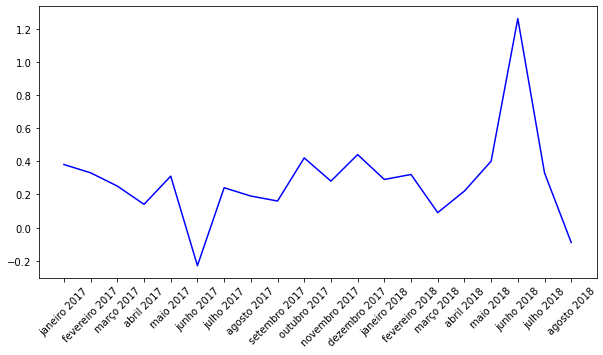

In [17]:
#Importar tabela com taxa de desemprego mensal(fonte:IBGE)
inflacao = pd.read_excel(r'inflacao.xlsx')
inflacao['ipca'].astype(float)
#selecionar período de treino:
inflacao_train = inflacao[:20]
# plot
fig,ax = plt.subplots(figsize=(10,5))
plt.plot(inflacao_train['mês'], inflacao_train['ipca'], 'b')
plt.xticks(rotation=45)
plt.show()

In [21]:
print('Table: Inflação')
inflacao.info(verbose=True)

Table: Inflação
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mês     48 non-null     object 
 1   ipca    48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 896.0+ bytes


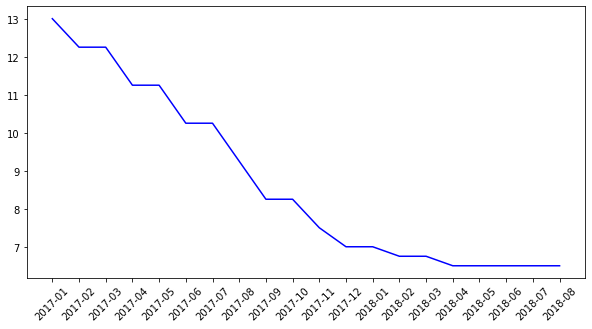

In [19]:
#Importar tabela com taxa Selic
selic = pd.read_excel(r'selic.xlsx')
selic['selic'].astype(float)
#selecionar período de treino:
selic_train = selic[:20]
# plot
fig,ax = plt.subplots(figsize=(10,5))
plt.plot(selic_train['mês'], selic_train['selic'], 'b')
plt.xticks(rotation=45)
plt.show()

In [20]:
print('Table: Selic')
selic.info(verbose=True)

Table: Selic
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mês     39 non-null     object 
 1   selic   39 non-null     float64
dtypes: float64(1), object(1)
memory usage: 752.0+ bytes


In [ ]:
#Regressão
#É o ato de prever, a partir de dados históricos, dados no futuro.
#Em Estatística, o termo a se procurar é Análise de Regressão.
#Este, estuda a relação entre duas ou mais variáveis, em que uma depende de outra ou outras.
#Quando eu tenho uma relação de um para um, eu tenho uma Regressão Linear Simples
#(que vou chamar de RLS daqui para frente), e quando eu tenho uma relação de um para muitos,
#eu tenho uma Regressão Linear Múltipla (RLM).

#variável preditora: é a variável independente, que tem o poder de influenciar na variável que nós queremos encontrar.
#No exemplo do preço da casa, a variável preditora pode ser o seu tamanho,
#a quantidade de quartos ou alguma outra informação. 
#variável alvo ou dependente: é a variável que queremos prever. No nosso exemplo, será o preço da casa. 

#Ordinary Least Squares (OLS). Tal método, visa buscar o melhor valor que os coeficientes possam atingir,
#de maneira que a diferença entre o valor predito pela função e o real, sejam os menores.

#Teste de Significância individuais ou p-values dos coeficientes: diz o quanto das variáveis
#preditoras explicam a variável alvo. A métrica padrão é o p-value ser menor que 0.05.
#Coeficiente R²: diz o quanto o meu modelo explica seus resultados. É um valor entre 0 e 1. Quanto mais próximo de 1, melhor.

In [136]:
# variável preditora
x = pib_mes_train['pib']
# variável alvo
y = orders_month['price']

import statsmodels.api as sm

x_sm = sm.add_constant(x)
#treinar o modelo:
results = sm.OLS(y, x_sm).fit()
#estatísticas do modelo
results.summary()
# previsões para o conjunto de treino
forecast_sales = results.predict(x_sm)

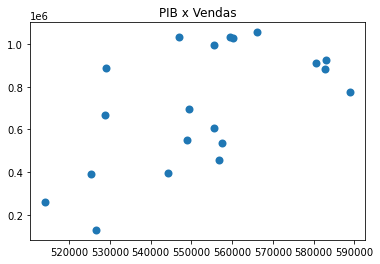

array([[7.933621]])

In [350]:
plt.scatter(pib_mes_train['pib'], orders_month['price'])
plt.title('PIB x Vendas')
plt.show()

# criando e treinando o modelo
model = LinearRegression()
model.fit(pib_mes_train[['pib']], orders_month[['price']])
# para visualizar os coeficientes encontrados
model.coef_

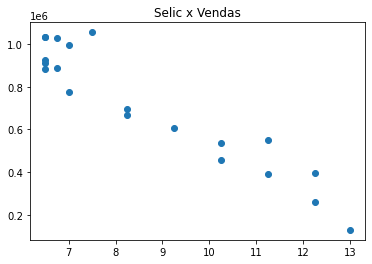

In [354]:
plt.scatter(selic_train['selic'], orders_month['price'])
plt.title('Selic x Vendas')
plt.show()

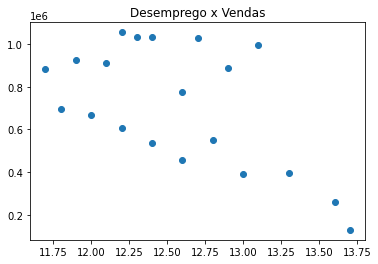

In [346]:
plt.scatter(desemprego_train['taxa'], orders_month['price'])
plt.title('Desemprego x Vendas')
plt.show()

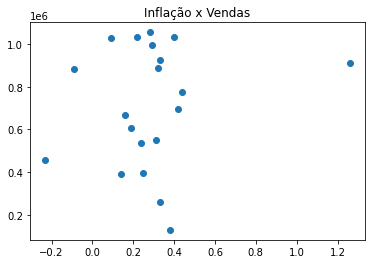

In [345]:
plt.scatter(inflacao_train['ipca'], orders_month['price'])
plt.title('Inflação x Vendas')
plt.show()

In [377]:
#REGRESSÃO LINEAR MÚLTIPLA:

# variáveis preditoras
x1 = pib_mes_train['pib']
x2 = desemprego_train['taxa']
x3 = inflacao_train['ipca']
x4 = selic_train['selic']
# variável alvo
y = orders_month['price']

x = np.column_stack((x1,x2,x3,x4))  #Agrupa as variaveis preditoras em uma só
x = sm.add_constant(x, prepend=True) #Adiciona a coluna das constantes

results = sm.OLS(y, x).fit()

forecast_sales = results.predict(x)

In [406]:
print(results.params)
print(results.summary())

const    955128.85
x1            0.38
x2        49812.65
x3       -28219.49
x4      -123387.18
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     35.11
Date:                Mon, 01 Feb 2021   Prob (F-statistic):           1.88e-07
Time:                        22:24:53   Log-Likelihood:                -255.61
No. Observations:                  20   AIC:                             521.2
Df Residuals:                      15   BIC:                             526.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

Previsão de 2017/09 até 2018/08:  10891418.83000034
Previsão de 2018/09 até 2019/08:  12643546.1779
Aumento:  16.087227708785175


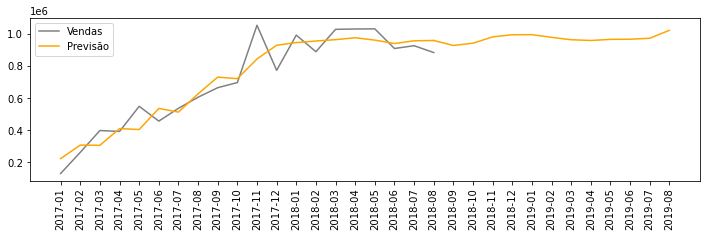

In [426]:
#Previsão para 1 ano além do período de treino:
fig,ax = plt.subplots(figsize=(12,3))
plt.plot(orders_month['mes_ano'], orders_month['price'], 'gray',
         orders_month['mes_ano'], forecast_sales, 'orange',
         variaveisPreditoras['mes'], variaveisPreditoras['forecast'], 'orange')
plt.legend(["Vendas","Previsão"])
print("Previsão de 2017/09 até 2018/08: ",orders_month['price'][8:20].sum())
print("Previsão de 2018/09 até 2019/08: ",variaveisPreditoras['forecast'].sum())
print("Aumento: ",(variaveisPreditoras['forecast'].sum()-orders_month['price'][8:20].sum())/orders_month['price'][8:20].sum()*100)
plt.xticks(rotation=90)
plt.show()

In [23]:
variaveisPreditoras = pd.DataFrame([])
variaveisPreditoras['mes'] = pib_mes['mes'][19:32]
variaveisPreditoras['pib'] = pib_mes['pib'][19:32]
variaveisPreditoras['taxa'] = desemprego['taxa'][19:32]
variaveisPreditoras['ipca'] = inflacao['ipca'][19:32]
variaveisPreditoras['selic'] = selic['selic'][19:32]
variaveisPreditoras['forecast'] = 955128.85 + pib_mes['pib']*0.38 + desemprego['taxa']*49812.65 + inflacao['ipca']*-28219.49 + selic['selic']*-123387.18
variaveisPreditoras

,mes,pib,taxa,ipca,selic,forecast
19,2018-08,582757.00,11.70,-0.09,6.50,959907.60
20,2018-09,556777.00,11.60,0.48,6.50,928968.82
21,2018-10,591984.00,11.60,0.45,6.50,943194.07
22,2018-11,593927.00,12.00,-0.21,6.50,982482.33
23,2018-12,603155.00,12.40,0.15,6.50,995755.02
24,2019-01,578453.00,12.70,0.32,6.50,996514.74
25,2019-02,567985.00,12.50,0.43,6.50,979470.22
26,2019-03,579173.00,12.30,0.75,6.50,964728.90
27,2019-04,592916.00,12.00,0.57,6.50,960086.95
28,2019-05,604607.00,11.80,0.13,6.50,966983.58
